# Exercise Sheet 7
This Notebook contains Exercise 20-22

# Exercise 20
This Exercise lays the base for the next ones!

We consider the advection diffusion problem
on the one-dimensional domain $\Omega=(0,1)\subset\mathbb{R}$.
\begin{aligned}
- \Delta u + \beta\cdot\nabla u &= f && \text{ in } \Omega, \\
u &= g && \text{on } \partial\Omega .
\end{aligned}
With $\beta=1$, $f(x)=\sin(11\pi x)$, and homogeneous Dirichlet data $g=0$, the problem becomes
# Exercise 1(a): Exact solution in 1D

## Step 1: Homogeneous solution
Solve $u''-u'=0$. The characteristic polynomial is $r^2-r=0$, hence $r\in\{0,1\}$, and
$u_h(x)=C_1 + C_2 e^x.$

## Step 2: Particular solution
Use the ansatz $u_p(x)=A\sin(kx)+B\cos(kx)$. Then
$u_p'(x)=Ak\cos(kx)-Bk\sin(kx),\qquad
u_p''(x)=-Ak^2\sin(kx)-Bk^2\cos(kx),$
so
$u_p''-u_p'
=
\bigl(-(k^2A)+kB\bigr)\sin(kx)
+
\bigl(-(k^2B)-kA\bigr)\cos(kx).$
Matching $u_p''-u_p'=-\sin(kx)$ yields the linear system
$-(k^2A)+kB=-1,\qquad -(k^2B)-kA=0.$
Solving gives
$A=\frac{1}{k^2+1},\qquad B=-\frac{1}{k(k^2+1)}.$
Thus
$u_p(x)=\frac{1}{k^2+1}\sin(kx)-\frac{1}{k(k^2+1)}\cos(kx).$

## Step 3: Impose boundary conditions
The general solution is $u=u_h+u_p$:
$u(x)=C_1+C_2e^x+\frac{1}{k^2+1}\sin(kx)-\frac{1}{k(k^2+1)}\cos(kx).$

From $u(0)=0$ we obtain
$C_1+C_2-\frac{1}{k(k^2+1)}=0
\quad\Rightarrow\quad
C_1=\frac{1}{k(k^2+1)}-C_2.$

From $u(1)=0$ and $\sin(k)=\sin(11\pi)=0$, $\cos(k)=\cos(11\pi)=-1$,
$0=C_1+C_2e+\frac{1}{k(k^2+1)}.$
Substituting $C_1$ gives
$0=\left(\frac{1}{k(k^2+1)}-C_2\right)+C_2e+\frac{1}{k(k^2+1)}
=\frac{2}{k(k^2+1)}+C_2(e-1),$
hence
$C_2=-\frac{2}{k(k^2+1)(e-1)},\qquad
C_1=\frac{e+1}{k(k^2+1)(e-1)}.$

## Final closed-form solution
With $k=11\pi$,
$\boxed{
u(x)=\frac{e+1-2e^x}{k(k^2+1)(e-1)}
+\frac{1}{k^2+1}\sin(kx)
-\frac{1}{k(k^2+1)}\cos(kx),
\qquad k=11\pi.
}$
This satisfies $-u''+u'=\sin(11\pi x)$ on $(0,1)$ and $u(0)=u(1)=0$.




In [5]:
# run imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from ngsolve import *
from ngsolve.webgui import Draw
import ngsolve as ng

from netgen.occ import * 
from ngsolve import x, y, sqrt, atan2, sin

from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Callable, Dict, Iterable, List, Mapping, Optional, Sequence, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt

## Helpers
This is the framework for reusing the shared code between all experiments
calculating convergence for different parameters based on a specific solver-mesh-domain
plotting and drawing my results
this saves me from copying and adopting the same parts on different places and possibly introducing errrors.

In [6]:
# general helpers


Number = Union[int, float]


def _as_list(x: Union[Number, Sequence[Number]]) -> List[Number]:
    return list(x) if isinstance(x, (list, tuple, np.ndarray)) else [x]


def compute_rates(errors: Sequence[float], hs: Sequence[float]) -> List[float]:
    """
    Local rates between consecutive refinements:
        p_i = log(E_i / E_{i+1}) / log(h_i / h_{i+1})
    Length: len(errors) - 1
    """
    rates: List[float] = []
    for i in range(len(errors) - 1):
        Ei, Ej = errors[i], errors[i + 1]
        hi, hj = hs[i], hs[i + 1]
        if Ej == 0 or hi == hj:
            rates.append(float("nan"))
        else:
            rates.append(float(np.log(Ei / Ej) / np.log(hi / hj)))
    return rates


def _annotate_rates(ax, hs, errs, rates, y_offset=0.05):
    for i, r in enumerate(rates):
        x_mid = np.sqrt(hs[i] * hs[i + 1])
        y_mid = np.sqrt(errs[i] * errs[i + 1])
        ax.text(x_mid, y_mid * (1 + y_offset), f"{r:.2f}", fontsize=9, ha="center")




# --- Type signatures for your custom pieces ----------------------------------

# Solver signature: you implement this per PDE/method.
# It should accept (h, order, **params) and return (gfu, mesh, extra_dict).
SolveFn = Callable[..., Tuple[Any, Any, Dict[str, Any]]]

# Error evaluators: you implement these once per exercise (because they depend on exact solution objects).
ErrorFn = Callable[[Any, Any, Dict[str, Any]], float]


def run_convergence(
    solve_fn: SolveFn,
    hs: Union[Number, Sequence[Number]],
    orders: Union[int, Sequence[int]] = 1,
    params_list: Optional[Sequence[Dict[str, Any]]] = None,
    err_L2_fn: Optional[ErrorFn] = None,
    err_H1_fn: Optional[ErrorFn] = None,
    plot: bool = True,
    title: str = "Error convergence",
) -> List[RunResult]:
    """
    Generic convergence runner.

    - solve_fn: your PDE solver, returns (gfu, mesh, extra).
    - hs: one h or list of h.
    - orders: one order or list of orders.
    - params_list: list of parameter dicts (e.g. [{"eps":1.0}, {"eps":1e-4}]).
                  If None, uses a single empty dict.
    - err_*_fn: functions computing errors from (gfu, mesh, extra).

    Returns: list of RunResult (one per combination).
    """
    hs_list = [float(v) for v in _as_list(hs)]
    orders_list = [int(v) for v in _as_list(orders)]
    params_list = list(params_list) if params_list is not None else [dict()]

    results: List[RunResult] = []

    # Run all combinations
    for p in params_list:
        for order in orders_list:
            for h in hs_list:
                gfu, mesh, extra = solve_fn(h=h, order=order, **p)

                if err_L2_fn is None or err_H1_fn is None:
                    raise ValueError("Provide both err_L2_fn and err_H1_fn")

                eL2 = float(err_L2_fn(gfu, mesh, extra))
                eH1 = float(err_H1_fn(gfu, mesh, extra))

                spec = RunSpec(h=h, order=order, params=dict(p))
                results.append(RunResult(spec=spec, err_L2=eL2, err_H1=eH1, extra=extra))

    # Plot grouped by (params, order)
    if plot:
        _plot_results(results, title=title)

    return results


def _group_key(rr: RunResult) -> Tuple[Tuple[Tuple[str, Any], ...], int]:
    # Sort params to make key stable
    pkey = tuple(sorted(rr.spec.params.items(), key=lambda kv: kv[0]))
    return (pkey, rr.spec.order)


def _plot_results(results: List[RunResult], title: str):
    groups: Dict[Tuple[Tuple[Tuple[str, Any], ...], int], List[RunResult]] = {}
    for rr in results:
        groups.setdefault(_group_key(rr), []).append(rr)

    fig, ax = plt.subplots(figsize=(9, 6))

    for (pkey, order), rrs in groups.items():
        rrs_sorted = sorted(rrs, key=lambda x: x.spec.h, reverse=True)  # coarse -> fine

        hs = [r.spec.h for r in rrs_sorted]
        eL2 = [r.err_L2 for r in rrs_sorted]
        eH1 = [r.err_H1 for r in rrs_sorted]

        rates_L2 = compute_rates(eL2, hs)
        rates_H1 = compute_rates(eH1, hs)

        label_suffix = f"p={order}"
        if len(pkey) > 0:
            pretty = ", ".join(f"{k}={v}" for k, v in pkey)
            label_suffix += f", {pretty}"

        ax.loglog(hs, eL2, marker="o", linestyle="--", label=f"L2 ({label_suffix})")
        ax.loglog(hs, eH1, marker="s", linestyle="-.", label=f"H1 ({label_suffix})")

        _annotate_rates(ax, hs, eL2, rates_L2, y_offset=0.05)
        _annotate_rates(ax, hs, eH1, rates_H1, y_offset=0.05)

    ax.set_xlabel("mesh size h")
    ax.set_ylabel("Error")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both")
    plt.show()


def results_table(results: List[RunResult]) -> str:
    """
    Returns a pretty plain-text table (good for notebooks).
    Groups by params+order, computes local rates.
    """
    groups: Dict[Tuple[Tuple[Tuple[str, Any], ...], int], List[RunResult]] = {}
    for rr in results:
        groups.setdefault(_group_key(rr), []).append(rr)

    lines: List[str] = []
    for (pkey, order), rrs in groups.items():
        rrs_sorted = sorted(rrs, key=lambda x: x.spec.h, reverse=True)
        hs = [r.spec.h for r in rrs_sorted]
        eL2 = [r.err_L2 for r in rrs_sorted]
        eH1 = [r.err_H1 for r in rrs_sorted]
        rates_L2 = compute_rates(eL2, hs)
        rates_H1 = compute_rates(eH1, hs)

        header = f"order={order}"
        if len(pkey) > 0:
            header += " | " + ", ".join(f"{k}={v}" for k, v in pkey)
        lines.append(header)
        lines.append("h\t\tL2 error\t\tL2 rate\t\tH1 error\t\tH1 rate")
        lines.append("-" * 88)

        for i in range(len(hs)):
            h_i = hs[i]
            l2 = eL2[i]
            h1 = eH1[i]
            rL2 = "" if i == 0 else f"{rates_L2[i-1]:.3f}"
            rH1 = "" if i == 0 else f"{rates_H1[i-1]:.3f}"
            lines.append(f"{h_i:.5e}\t{l2:.5e}\t{rL2:>8}\t{h1:.5e}\t{rH1:>8}")

        lines.append("")  # blank line between groups

    return "\n".join(lines)




Params = Dict[str, Any]


def _params_key(params: Mapping[str, Any]) -> Tuple[Tuple[str, Any], ...]:
    return tuple(sorted(params.items(), key=lambda kv: kv[0]))


def _h_key(h: float, ndigits: int = 12) -> float:
    # Avoid float-key pain (0.1 vs 0.1000000000003)
    return round(float(h), ndigits)


@dataclass(frozen=True)
class RunSpec:
    h: float
    order: int
    params: Tuple[Tuple[str, Any], ...]  # canonicalized params


@dataclass
class SolutionStore:
    gfu: Any
    mesh: Any
    extra: Dict[str, Any]  # anything else you want to keep (tau, dofs, etc.)


@dataclass
class RunResult:
    spec: RunSpec
    err_L2: float
    err_H1: float
    solution: Optional[SolutionStore] = None  # None unless store_solution=True

class StudyGroup:
    """
    A view of one fixed (order, params) slice.
    Allows indexing by h: group[h] -> RunResult
    """

    def __init__(self, *, order: int, params: Params, results: List[RunResult], h_ndigits: int = 12):
        self.order = int(order)
        self.params = dict(params)
        self._pkey = _params_key(self.params)
        self._h_ndigits = h_ndigits

        # index by h
        self._by_h: Dict[float, RunResult] = {}
        for r in results:
            if r.spec.order != self.order or r.spec.params != self._pkey:
                continue
            hk = _h_key(r.spec.h, self._h_ndigits)
            self._by_h[hk] = r

        if not self._by_h:
            raise KeyError(f"No results for order={self.order}, params={self.params}")

    def hs(self) -> List[float]:
        return sorted(self._by_h.keys(), reverse=True)  # coarse -> fine

    def __iter__(self):
        for h in self.hs():
            yield self._by_h[h]

    def __getitem__(self, h: float) -> RunResult:
        hk = _h_key(h, self._h_ndigits)
        if hk not in self._by_h:
            raise KeyError(f"h={h} not found. Available h: {self.hs()}")
        return self._by_h[hk]

    def rates(self) -> Dict[str, List[float]]:
        hs = self.hs()
        eL2 = [self._by_h[h].err_L2 for h in hs]
        eH1 = [self._by_h[h].err_H1 for h in hs]
        return {
            "L2": compute_rates(eL2, hs),
            "H1": compute_rates(eH1, hs),
        }

    def table(self) -> str:
        hs = self.hs()
        eL2 = [self._by_h[h].err_L2 for h in hs]
        eH1 = [self._by_h[h].err_H1 for h in hs]
        rL2 = compute_rates(eL2, hs)
        rH1 = compute_rates(eH1, hs)

        header = f"order={self.order}"
        if self.params:
            header += " | " + ", ".join(f"{k}={v}" for k, v in sorted(self.params.items()))
        lines = [header,
                 "h\t\tL2 error\t\tL2 rate\t\tH1 error\t\tH1 rate",
                 "-" * 88]
        for i, h in enumerate(hs):
            l2 = eL2[i]
            h1 = eH1[i]
            rrL2 = "" if i == 0 else f"{rL2[i-1]:.3f}"
            rrH1 = "" if i == 0 else f"{rH1[i-1]:.3f}"
            lines.append(f"{h:.5e}\t{l2:.5e}\t{rrL2:>8}\t{h1:.5e}\t{rrH1:>8}")
        return "\n".join(lines)

    def plot(self, *, title: Optional[str] = None):
        hs = self.hs()
        eL2 = [self._by_h[h].err_L2 for h in hs]
        eH1 = [self._by_h[h].err_H1 for h in hs]
        rL2 = compute_rates(eL2, hs)
        rH1 = compute_rates(eH1, hs)

        fig, ax = plt.subplots(figsize=(9, 6))
        ax.loglog(hs, eL2, marker="o", linestyle="--", label="L2 error")
        ax.loglog(hs, eH1, marker="s", linestyle="-.", label="H1 error")
        _annotate_rates(ax, hs, eL2, rL2, y_offset=0.05)
        _annotate_rates(ax, hs, eH1, rH1, y_offset=0.05)

        ax.set_xlabel("mesh size h")
        ax.set_ylabel("Error")
        ax.set_title(title or "Error convergence")
        ax.legend()
        ax.grid(True, which="both")
        plt.show()

class ConvergenceStudy:
    """
    Stores results for multiple (h, order, params) combinations.
    Provides:
      - group(order=..., params=...) -> StudyGroup with [h] indexing
      - study[h] shortcut if unambiguous
      - plotting and table helpers
      - optional solution storage via store_solution flag
    """

    def __init__(self, *, h_ndigits: int = 12):
        self._results: List[RunResult] = []
        self._h_ndigits = h_ndigits

    @property
    def results(self) -> List[RunResult]:
        return list(self._results)

    def add(self, rr: RunResult) -> None:
        self._results.append(rr)

    def orders(self) -> List[int]:
        return sorted(set(r.spec.order for r in self._results))

    def params_keys(self) -> List[Tuple[Tuple[str, Any], ...]]:
        return sorted(set(r.spec.params for r in self._results))

    def group(self, *, order: int, params: Optional[Params] = None) -> StudyGroup:
        return StudyGroup(order=order, params=params or {}, results=self._results, h_ndigits=self._h_ndigits)

    def __getitem__(self, h: float) -> RunResult:
        """
        Convenience indexing: study[h]
        Only works if there is exactly one (order, params) group present.
        """
        orders = self.orders()
        pkeys = self.params_keys()
        if len(orders) != 1 or len(pkeys) != 1:
            raise KeyError(
                "study[h] is ambiguous (multiple orders or parameter sets). "
                "Use study.group(order=..., params=...)[h] instead."
            )
        order = orders[0]
        params = dict(pkeys[0])
        return self.group(order=order, params=params)[h]

    def table_all(self) -> str:
        lines: List[str] = []
        for order in self.orders():
            for pkey in self.params_keys():
                grp = self.group(order=order, params=dict(pkey))
                lines.append(grp.table())
                lines.append("")
        return "\n".join(lines).strip()

def run_study(
    *,
    solve_fn: SolveFn,
    hs: Union[Number, Sequence[Number]],
    orders: Union[int, Sequence[int]] = 1,
    params_list: Optional[Sequence[Params]] = None,
    err_L2_fn: ErrorFn,
    err_H1_fn: ErrorFn,
    store_solution: bool = False,
) -> ConvergenceStudy:
    hs_list = [float(v) for v in (hs if isinstance(hs, (list, tuple, np.ndarray)) else [hs])]
    orders_list = [int(v) for v in (orders if isinstance(orders, (list, tuple, np.ndarray)) else [orders])]
    params_list = list(params_list) if params_list is not None else [dict()]

    study = ConvergenceStudy()

    for p in params_list:
        pkey = _params_key(p)
        for order in orders_list:
            for h in hs_list:
                gfu, mesh, extra = solve_fn(h=h, order=order, **p)

                eL2 = float(err_L2_fn(gfu, mesh, extra))
                eH1 = float(err_H1_fn(gfu, mesh, extra))

                sol = None
                if store_solution:
                    sol = SolutionStore(gfu=gfu, mesh=mesh, extra=dict(extra))

                rr = RunResult(
                    spec=RunSpec(h=float(h), order=int(order), params=pkey),
                    err_L2=eL2,
                    err_H1=eH1,
                    solution=sol,
                )
                study.add(rr)

    return study

import ngsolve.webgui as webgui

def draw_run(rr: RunResult, *, name: str = "u_h", **draw_kwargs):
    if rr.solution is None:
        raise ValueError("No stored solution. Re-run with store_solution=True.")
    d = webgui.Draw(rr.solution.gfu, name=name, **draw_kwargs)
    return d


def draw_group(grp: StudyGroup, *, hs: Optional[Sequence[float]] = None, name_prefix: str = "u_h", **draw_kwargs):
    """
    Draw multiple runs from the same group. If hs is None, draws all hs in the group.
    """
    hs_to_draw = list(hs) if hs is not None else grp.hs()
    for h in hs_to_draw:
        rr = grp[h]
        name = f"{name_prefix} (h={h:g}, p={grp.order})"
        if grp.params:
            suffix = ", ".join(f"{k}={v}" for k, v in sorted(grp.params.items()))
            name += f", {suffix}"
        draw_run(rr, name=name, **draw_kwargs)


# --- Type signatures for user-provided functions -----------------------------

# solver: you implement per PDE
# must return (gfu, mesh, extra_dict)
SolveFn = Callable[..., Tuple[Any, Any, Dict[str, Any]]]

# error evaluators: you implement per exact solution
ErrorFn = Callable[[Any, Any, Dict[str, Any]], float]

## Usage Example with poisson problem

In [7]:

# --- Imports (explicit, no *) ---
import numpy as np
from math import pi, sqrt

from netgen.geom2d import unit_square
from ngsolve import (
    Mesh, H1, GridFunction, BilinearForm, LinearForm, SymbolicBFI, SymbolicLFI,
    grad, dx, x, y, sin, Integrate, Draw, CGSolver, Preconditioner, TaskManager
)

# --- Exact solution (Poisson on unit square) ---
# Choose u(x,y) = sin(pi x) sin(pi y), then
# -Δu = 2*pi^2 * sin(pi x) sin(pi y)
uex = CF( x*(1-x)*y*(1-y) ) 
uex = CF( sin(pi*x)*sin(pi*y) )
graduex = CF( (uex.Diff(x), uex.Diff(y) ))
divgraduex = CF( graduex[0].Diff(x) + graduex[1].Diff(y) )
def poisson_solve(*, h: float, order: int, **params):
    """
    Solve: -Δu = f in Ω, u=0 on ∂Ω
    Returns (gfu, mesh, extra)
    """
    # 1) Domain & mesh
    ngmesh = unit_square.GenerateMesh(maxh=h)
    mesh = Mesh(ngmesh)

    # 2) FE space (Dirichlet everywhere)
    V = H1(mesh, order=order, dirichlet=".*")

    # 3) Trial/ test
    u, v = V.TrialFunction(), V.TestFunction()

    # 4) Forms
    a = BilinearForm(V, symmetric=True)
    a += grad(u) * grad(v) * dx

    L = LinearForm(V)
    L += - divgraduex*v*dx

    # 5) Solve
    gfu = GridFunction(V)
    pre = Preconditioner(a, "multigrid")  # "direct" also fine for small meshes

    with TaskManager():
        a.Assemble()
        L.Assemble()
        gfu.vec.data = a.mat.Inverse(freedofs = V.FreeDofs())* L.vec

    # Put any metadata you like into extra (dofs, etc.)
    extra = {"dofs": V.ndof}
    return gfu, mesh, extra


# --- Error evaluators ---
def poisson_err_L2(gfu, mesh, extra):
    return sqrt(Integrate((gfu - uex)**2, mesh))

from ngsolve import InnerProduct, grad, Integrate

def poisson_err_H1(gfu, mesh, extra):
    diff = grad(gfu) - graduex
    return float(sqrt(Integrate(InnerProduct(diff, diff), mesh)))

order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
3.00000e-01	4.54040e-05	        	9.14401e-04	        
1.50000e-01	8.05747e-07	   5.816	3.44246e-05	   4.731
7.50000e-02	2.21674e-08	   5.184	1.93398e-06	   4.154
3.75000e-02	6.18679e-10	   5.163	1.10663e-07	   4.127
1.87500e-02	1.93935e-11	   4.996	7.03991e-09	   3.974


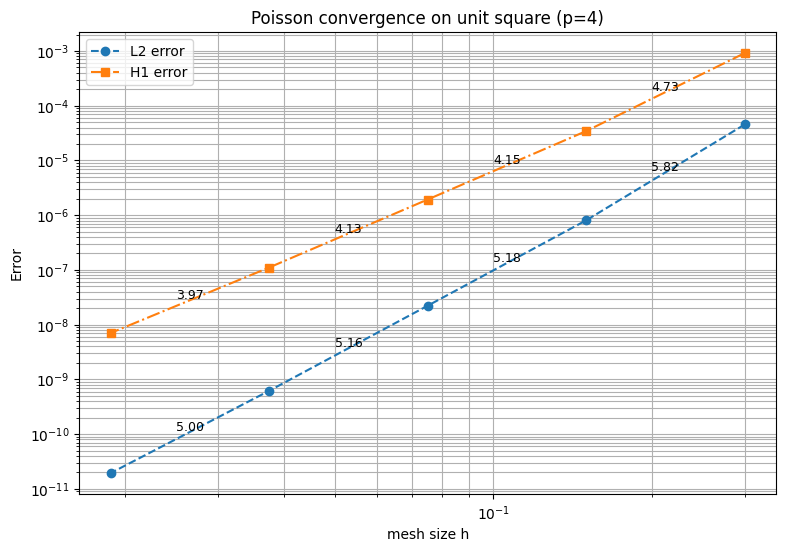

In [8]:
# Choose refinement ladder
hs = [0.3 / (2**i) for i in range(5)]
order = 4  # try 1,2,3...

study = run_study(
    solve_fn=poisson_solve,
    hs=hs,
    orders=order,
    params_list=[{}],          # no extra parameters for Poisson
    err_L2_fn=poisson_err_L2,
    err_H1_fn=poisson_err_H1,
    store_solution=True,       # set False if you only want error numbers
)

grp = study.group(order=order, params={})

print(grp.table())
grp.plot(title=f"Poisson convergence on unit square (p={order})")

In [9]:
# pick one of the hs you used above
h_pick = hs[-1]
rr = grp[h_pick]
draw_run(rr, name=f"u_h (h={h_pick:g}, p={order})")



WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

# Advection Diffusion


## Standard Galerkin

In [36]:


from math import pi
from ngsolve import x, sin, cos, exp, CF, Mesh, H1


def uex_duex_eps(eps: float):
    k = 11*pi
    denom = 1 + (eps*k)**2

    A = eps / denom
    B = -1 / (k*denom)

    q = exp(-1/eps)
    inv_em1 = q / (1 - q)

    C2 = -(2/(k*denom)) * inv_em1
    C1 = 1/(k*denom) - C2

    u  = C1 + C2*exp(x/eps) + A*sin(k*x) + B*cos(k*x)
    du = (C2/eps)*exp(x/eps) + A*k*cos(k*x) - B*k*sin(k*x)

    return CF(u), CF(du)

from ngsolve import Integrate
from math import sqrt

def err_L2_advecdiff(gfu, mesh, extra):
    uex = extra["uex"]
    return sqrt(Integrate((gfu - uex)**2, mesh))

from ngsolve import InnerProduct, grad

def err_H1_advecdiff(gfu, mesh, extra):
    duex = extra["duex"]
    return sqrt(Integrate((grad(gfu)[0] - duex)**2, mesh))



from ngsolve.meshes import Make1DMesh


def get_solver(eps, beta=1.0):
    uex, duex = uex_duex_eps(eps)

    def advec_diff_solver(*, h: float, order: int, **params):

        mesh = Make1DMesh(int(1/h))
        f = CF(sin(11 * pi * x))
        # boundary names: verify once with print(mesh.GetBoundaries())
        V = H1(mesh, order=order, dirichlet=".*")

        u, v = V.TnT()


        a = BilinearForm(V, symmetric=False)
        a += eps * InnerProduct(grad(u), grad(v)) * dx
        a += beta * grad(u)[0] * v * dx

        L = LinearForm(V)
        L += f * v * dx

        gfu = GridFunction(V)
        with TaskManager():
            a.Assemble()
            L.Assemble()
            gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs()) * L.vec

        extra = {
            "dofs": V.ndof,
            "eps": eps,
            "beta": beta,
            "uex": uex,
            "duex": duex,
        }
        return gfu, mesh, extra

    return advec_diff_solver

eps=1.0
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	5.96176e-05	        	5.78281e-03	        
1.00000e-01	2.71989e-06	   4.454	5.16025e-04	   3.486
5.00000e-02	9.17514e-08	   4.890	3.53119e-05	   3.869
2.50000e-02	2.91949e-09	   4.974	2.25771e-06	   3.967
1.25000e-02	9.16411e-11	   4.994	1.41911e-07	   3.992
6.25000e-03	2.86696e-12	   4.998	8.88203e-09	   3.998
3.12500e-03	8.96172e-14	   5.000	5.55324e-10	   3.999
1.56250e-03	2.80267e-15	   4.999	3.47111e-11	   4.000
7.81250e-04	2.25602e-16	   3.635	2.16975e-12	   4.000


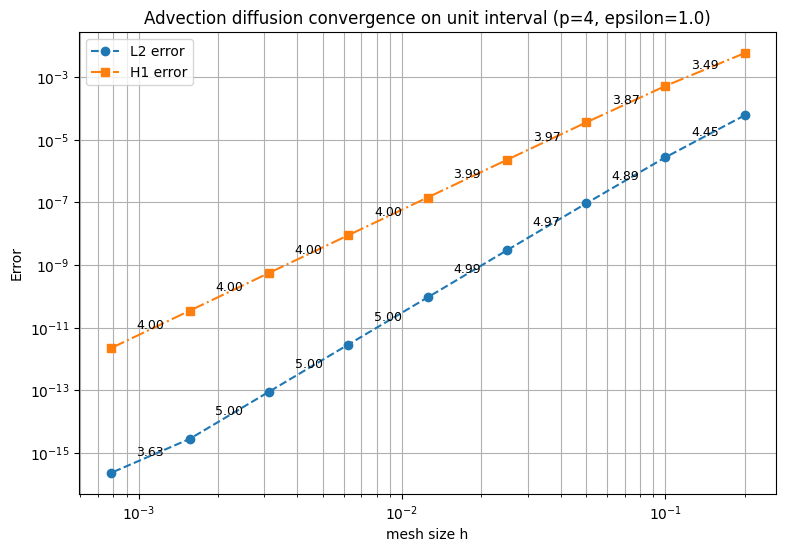

eps=0.1
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	6.43604e-04	        	5.43852e-02	        
1.00000e-01	2.68370e-05	   4.584	4.93334e-03	   3.463
5.00000e-02	8.87954e-07	   4.918	3.38901e-04	   3.864
2.50000e-02	2.81066e-08	   4.982	2.16893e-05	   3.966
1.25000e-02	8.81062e-10	   4.996	1.36364e-06	   3.991
6.25000e-03	2.75544e-11	   4.999	8.53539e-08	   3.998
3.12500e-03	8.61241e-13	   5.000	5.33660e-09	   3.999
1.56250e-03	2.99768e-14	   4.845	3.33571e-10	   4.000
7.81250e-04	2.25090e-14	   0.413	2.08513e-11	   4.000


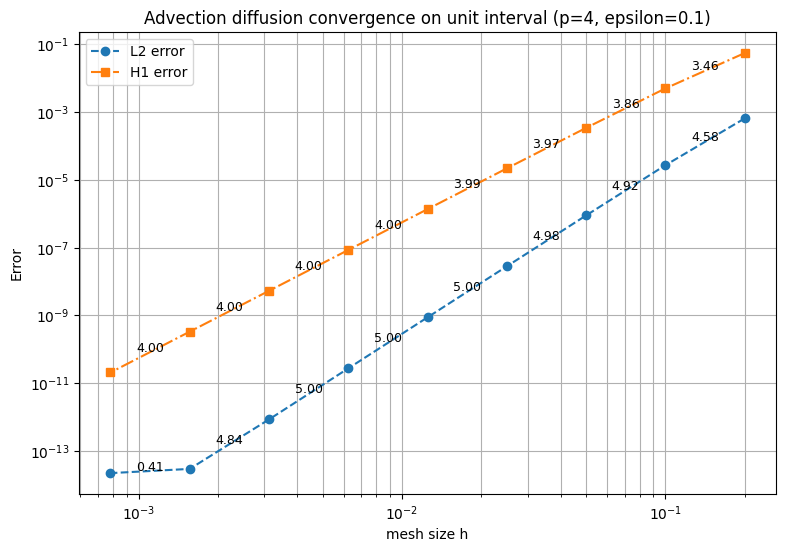

eps=0.01
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	6.80796e-03	        	2.27693e-01	        
1.00000e-01	5.62529e-04	   3.597	5.89668e-02	   1.949
5.00000e-02	5.94221e-05	   3.243	1.48782e-02	   1.987
2.50000e-02	2.99851e-06	   4.309	1.92827e-03	   2.948
1.25000e-02	1.09181e-07	   4.779	1.59348e-04	   3.597
6.25000e-03	3.54900e-09	   4.943	1.08200e-05	   3.880
3.12500e-03	1.11999e-10	   4.986	6.91172e-07	   3.969
1.56250e-03	3.50866e-12	   4.996	4.34379e-08	   3.992
7.81250e-04	1.09815e-13	   4.998	2.71865e-09	   3.998


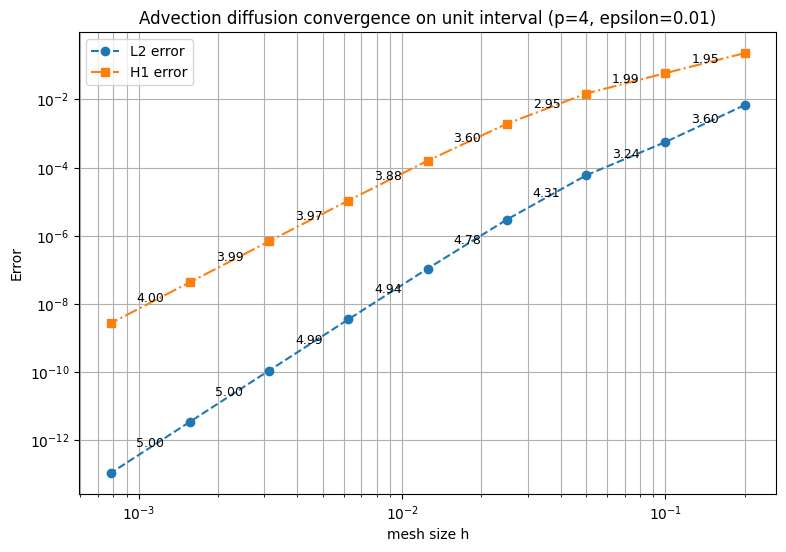

eps=0.001
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.03186e-01	        	2.08824e+00	        
1.00000e-01	6.73583e-03	   3.937	7.28486e-01	   1.519
5.00000e-02	3.12281e-03	   1.109	7.72917e-01	  -0.085
2.50000e-02	1.29621e-03	   1.269	9.07038e-01	  -0.231
1.25000e-02	9.45198e-04	   0.456	1.12078e+00	  -0.305
6.25000e-03	1.21412e-03	  -0.361	1.25980e+00	  -0.169
3.12500e-03	1.28689e-03	  -0.084	1.29026e+00	  -0.034
1.56250e-03	1.29240e-03	  -0.006	1.29250e+00	  -0.002
7.81250e-04	1.29257e-03	  -0.000	1.29257e+00	  -0.000


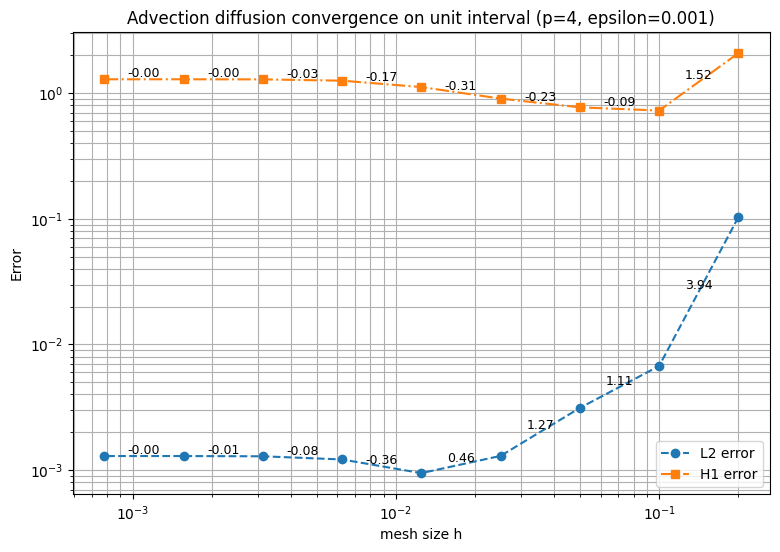

eps=0.0001
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.23554e+00	        	2.07341e+01	        
1.00000e-01	1.25125e-01	   3.304	4.97208e+00	   2.060
5.00000e-02	1.97512e-02	   2.663	2.75170e+00	   0.854
2.50000e-02	5.41407e-03	   1.867	2.25435e+00	   0.288
1.25000e-02	2.67107e-03	   1.019	2.27787e+00	  -0.015
6.25000e-03	1.27682e-03	   1.065	2.37926e+00	  -0.063
3.12500e-03	5.49890e-04	   1.215	2.69644e+00	  -0.181
1.56250e-03	2.85891e-04	   0.944	3.32986e+00	  -0.304
7.81250e-04	3.63158e-04	  -0.345	3.89470e+00	  -0.226


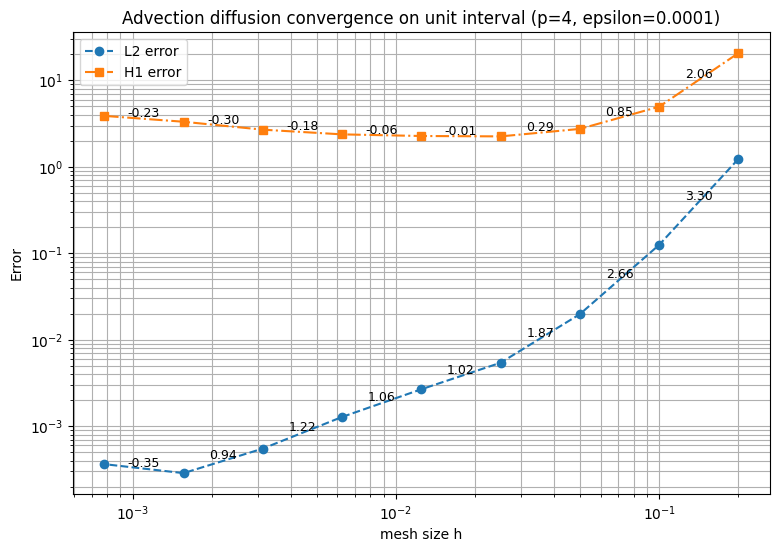

eps=1e-05
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.25979e+01	        	2.07326e+02	        
1.00000e-01	1.47634e+00	   3.093	4.93844e+01	   2.070
5.00000e-02	3.54724e-01	   2.057	2.50710e+01	   0.978
2.50000e-02	7.15412e-02	   2.310	1.27409e+01	   0.977
1.25000e-02	1.04598e-02	   2.774	7.66028e+00	   0.734
6.25000e-03	4.28689e-03	   1.287	7.09310e+00	   0.111
3.12500e-03	2.13936e-03	   1.003	7.10689e+00	  -0.003
1.56250e-03	1.06173e-03	   1.011	7.16241e+00	  -0.011
7.81250e-04	5.15563e-04	   1.042	7.37451e+00	  -0.042


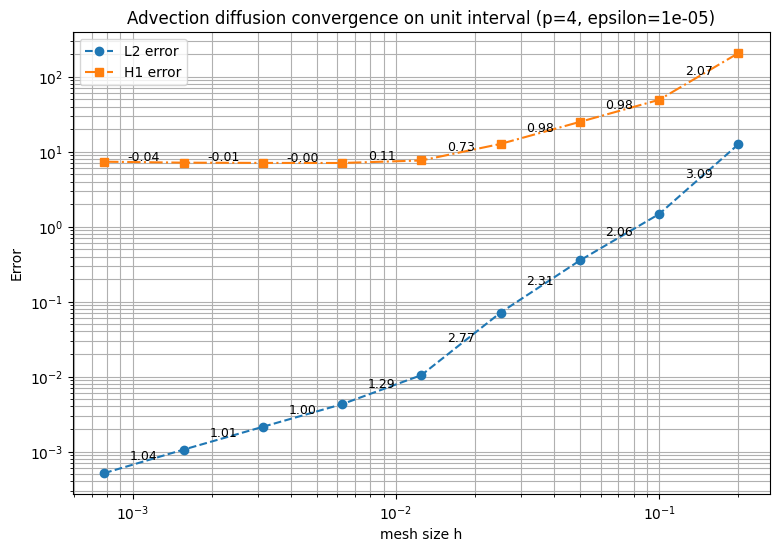

eps=1e-06
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26226e+02	        	2.07326e+03	        
1.00000e-01	1.50081e+01	   3.072	4.93810e+02	   2.070
5.00000e-02	3.78537e+00	   1.987	2.50443e+02	   0.979
2.50000e-02	9.26683e-01	   2.030	1.25319e+02	   0.999
1.25000e-02	2.12440e-01	   2.125	6.28216e+01	   0.996
6.25000e-03	3.79771e-02	   2.484	3.26433e+01	   0.944
3.12500e-03	6.96498e-03	   2.447	2.27914e+01	   0.518
1.56250e-03	3.39075e-03	   1.039	2.24171e+01	   0.024
7.81250e-04	1.69486e-03	   1.000	2.24242e+01	  -0.000


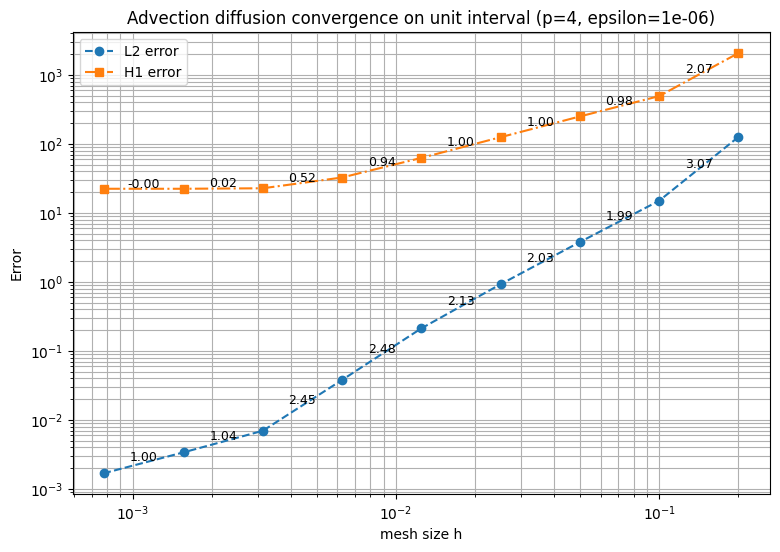

eps=1e-07
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26251e+03	        	2.07326e+04	        
1.00000e-01	1.50328e+02	   3.070	4.93810e+03	   2.070
5.00000e-02	3.80997e+01	   1.980	2.50441e+03	   0.979
2.50000e-02	9.51024e+00	   2.002	1.25298e+03	   0.999
1.25000e-02	2.35720e+00	   2.012	6.26526e+02	   1.000
6.25000e-03	5.69258e-01	   2.050	3.13392e+02	   0.999
3.12500e-03	1.23888e-01	   2.200	1.57716e+02	   0.991
1.56250e-03	1.91108e-02	   2.697	8.62977e+01	   0.870
7.81250e-04	5.37004e-03	   1.831	7.09829e+01	   0.282


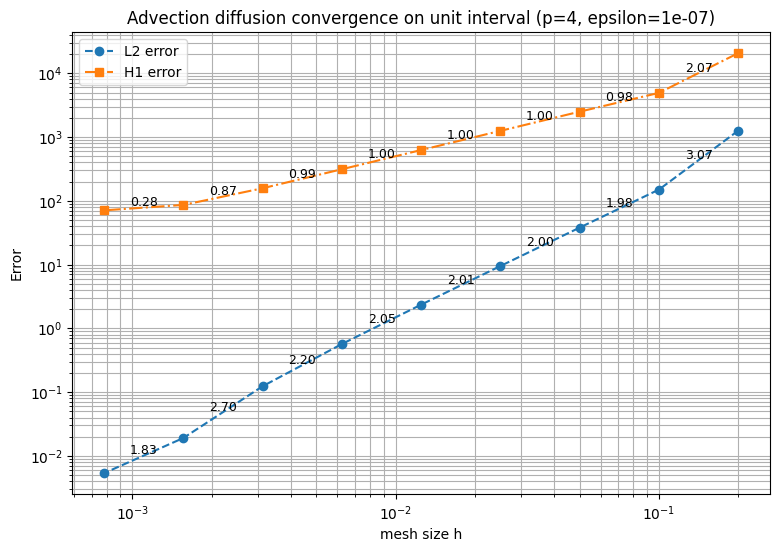

eps=1e-08
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26253e+04	        	2.07326e+05	        
1.00000e-01	1.50353e+03	   3.070	4.93810e+04	   2.070
5.00000e-02	3.81244e+02	   1.980	2.50441e+04	   0.979
2.50000e-02	9.53490e+01	   1.999	1.25297e+04	   0.999
1.25000e-02	2.38175e+01	   2.001	6.26509e+03	   1.000
6.25000e-03	5.93387e+00	   2.005	3.13256e+03	   1.000
3.12500e-03	1.46310e+00	   2.020	1.56638e+03	   1.000
1.56250e-03	3.46053e-01	   2.080	7.84013e+02	   0.998
7.81250e-04	6.93981e-02	   2.318	3.98466e+02	   0.976


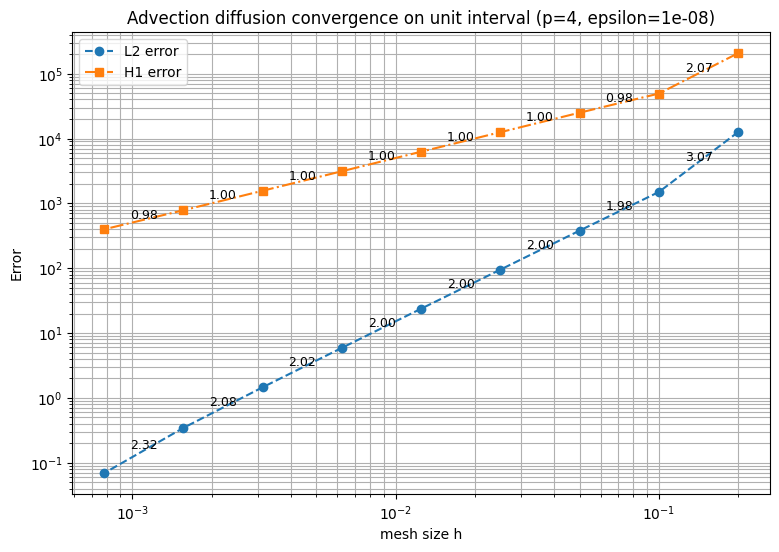

eps=1e-09
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26253e+05	        	2.07326e+06	        
1.00000e-01	1.50355e+04	   3.070	4.93810e+05	   2.070
5.00000e-02	3.81269e+03	   1.979	2.50441e+05	   0.979
2.50000e-02	9.53737e+02	   1.999	1.25297e+05	   0.999
1.25000e-02	2.38422e+02	   2.000	6.26509e+04	   1.000
6.25000e-03	5.95851e+01	   2.000	3.13255e+04	   1.000
3.12500e-03	1.48757e+01	   2.002	1.56628e+04	   1.000
1.56250e-03	3.69844e+00	   2.008	7.83146e+03	   1.000
7.81250e-04	9.04373e-01	   2.032	3.91639e+03	   1.000


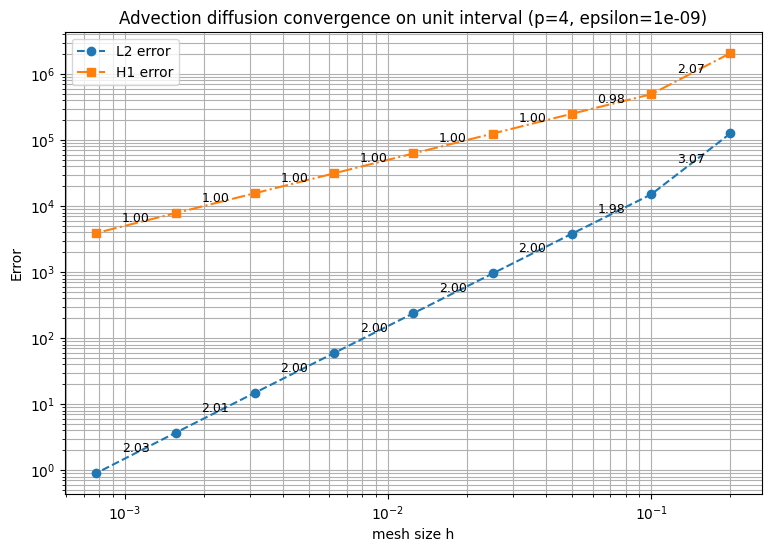

eps=1e-10
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26253e+06	        	2.07326e+07	        
1.00000e-01	1.50355e+05	   3.070	4.93810e+06	   2.070
5.00000e-02	3.81271e+04	   1.979	2.50441e+06	   0.979
2.50000e-02	9.53762e+03	   1.999	1.25297e+06	   0.999
1.25000e-02	2.38447e+03	   2.000	6.26509e+05	   1.000
6.25000e-03	5.96098e+02	   2.000	3.13255e+05	   1.000
3.12500e-03	1.49004e+02	   2.000	1.56628e+05	   1.000
1.56250e-03	3.72304e+01	   2.001	7.83138e+04	   1.000
7.81250e-04	9.28706e+00	   2.003	3.91570e+04	   1.000


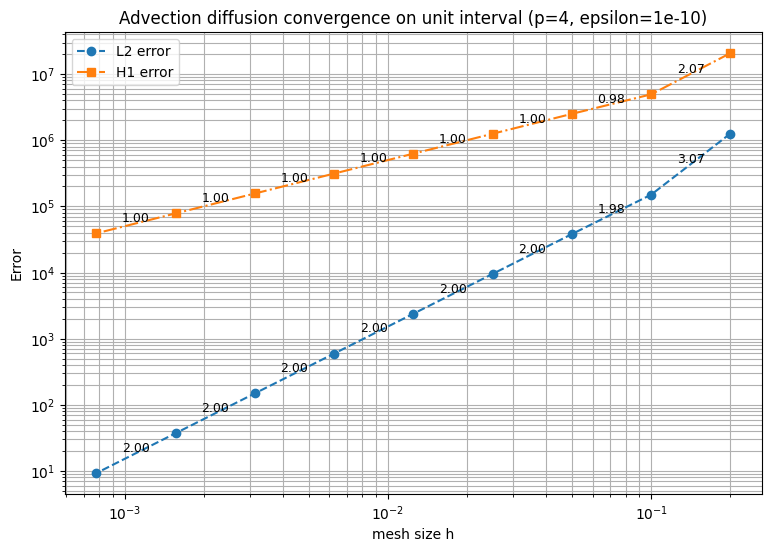

eps=1e-11
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26253e+07	        	2.07326e+08	        
1.00000e-01	1.50355e+06	   3.070	4.93810e+07	   2.070
5.00000e-02	3.81272e+05	   1.979	2.50441e+07	   0.979
2.50000e-02	9.53764e+04	   1.999	1.25297e+07	   0.999
1.25000e-02	2.38449e+04	   2.000	6.26509e+06	   1.000
6.25000e-03	5.96122e+03	   2.000	3.13255e+06	   1.000
3.12500e-03	1.49029e+03	   2.000	1.56628e+06	   1.000
1.56250e-03	3.72551e+02	   2.000	7.83138e+05	   1.000
7.81250e-04	9.31171e+01	   2.000	3.91569e+05	   1.000


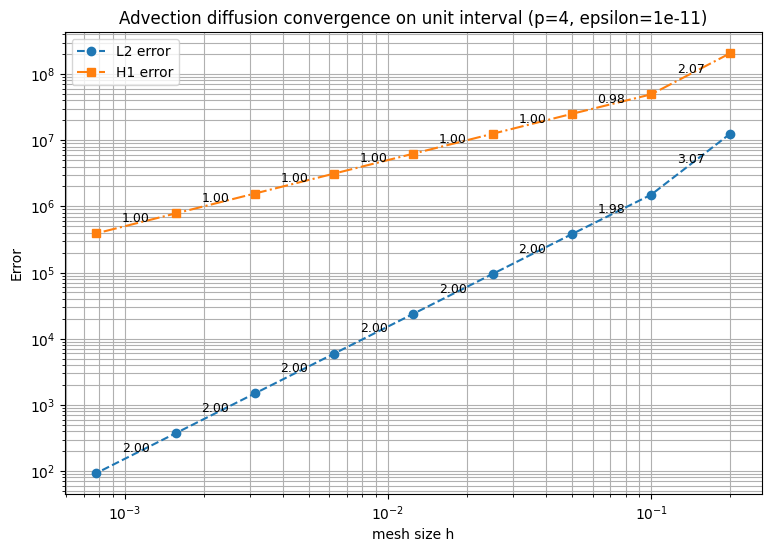

eps=1e-12
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	1.26253e+08	        	2.07326e+09	        
1.00000e-01	1.50355e+07	   3.070	4.93810e+08	   2.070
5.00000e-02	3.81271e+06	   1.979	2.50441e+08	   0.979
2.50000e-02	9.53764e+05	   1.999	1.25297e+08	   0.999
1.25000e-02	2.38449e+05	   2.000	6.26509e+07	   1.000
6.25000e-03	5.96125e+04	   2.000	3.13255e+07	   1.000
3.12500e-03	1.49031e+04	   2.000	1.56628e+07	   1.000
1.56250e-03	3.72576e+03	   2.000	7.83138e+06	   1.000
7.81250e-04	9.31418e+02	   2.000	3.91569e+06	   1.000


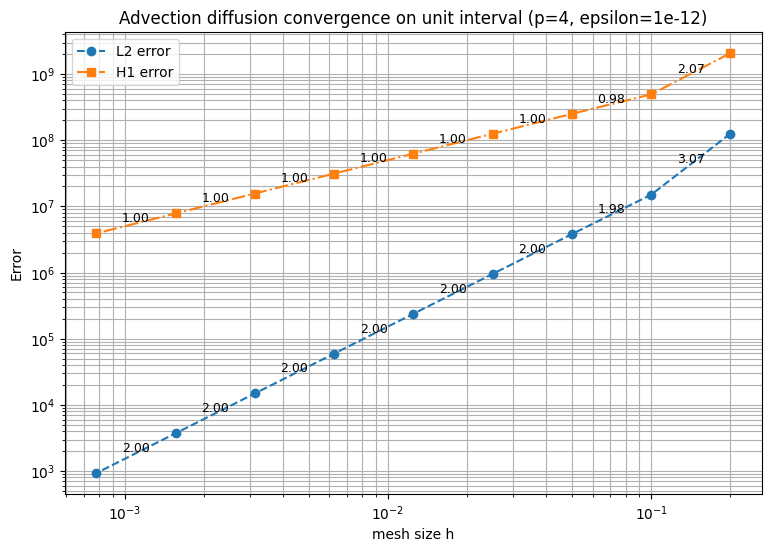

In [37]:
eps_list = [10.0**(-k) for k in range(0, 13)]   # 1e0 ... 1e-12


hs = [0.2 / (2**i) for i in range(9)]  # 0.2 ... 0.000390625

order = 4

all_studies = {}
for eps in eps_list:
    solver = get_solver(eps, beta=1)
    study = run_study(
        solve_fn=solver,
        hs=hs,
        orders=order,
        params_list=[{}],
        err_L2_fn=err_L2_advecdiff,
        err_H1_fn=err_H1_advecdiff,
        store_solution=True,
    )
    grp = study.group(order=order, params={})

    print(f"{eps=}")
    print(grp.table())
    grp.plot(title=f"Advection diffusion convergence on unit interval (p={order}, epsilon={eps})")
    all_studies[eps] = study

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def eval_gfu_1d(gfu, xs):
    """Evaluate GridFunction gfu at points xs ∈ [0,1]."""
    return np.array([gfu(x) for x in xs], dtype=float)

def plot_1d_solution(gfu, uex=None, *, eps=None, title=None, npts=2000):
    xs = np.linspace(0, 1, npts)
    uh = eval_gfu_1d(gfu, xs)

    plt.figure(figsize=(8, 4))
    plt.plot(xs, uh, label="u_h", lw=2)

    if uex is not None:
        uex_vals = eval_cf_1d(uex, xs)
        plt.plot(xs, uex_vals, "--", lw=2, label="u_exact")

    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.grid(True)
    if title:
        plt.title(title)
    if eps is not None:
        plt.title(title or f"1D advection–diffusion (ε={eps:g})")
    plt.legend()
    plt.tight_layout()
    plt.show()



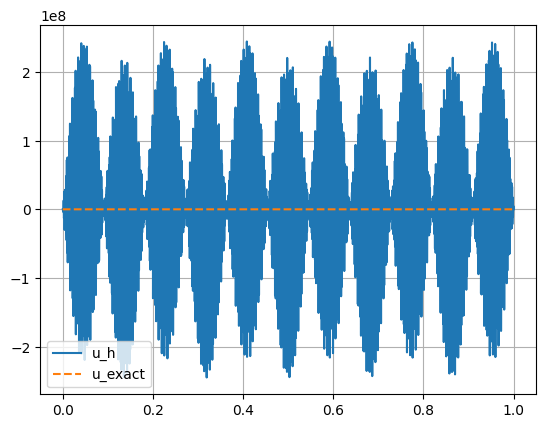

In [21]:
def eval_on_unit_interval(obj, mesh, xs):
    return np.array([float(obj(mesh(xi))) for xi in xs])

xs = np.linspace(0, 1, 2000)
rr = grp[hs[-1]]
gfu = rr.solution.gfu
uex = rr.solution.extra["uex"]

uh = eval_on_unit_interval(gfu, rr.solution.mesh, xs)
u  = eval_on_unit_interval(uex, rr.solution.mesh, xs)

plt.plot(xs, uh, label="u_h")
plt.plot(xs, u, "--", label="u_exact")
plt.grid(True); plt.legend();

## modified galerkin

In [45]:


def get_modified_solver(eps, beta=1.0):
    uex, duex = uex_duex_eps(eps)

    def modified_advec_diff_solver(*, h: float, order: int, **params):

        N = max(2, int(round(1/h)))          # IMPORTANT: round, not int-floor
        mesh = Make1DMesh(N)
        f = CF(sin(11 * pi * x))
        # boundary names: verify once with print(mesh.GetBoundaries())
        V = H1(mesh, order=order, dirichlet=".*")

        u, v = V.TnT()

        eps_h = eps + abs(beta) * h / 2
        a = BilinearForm(V, symmetric=False)
        a += eps_h * InnerProduct(grad(u), grad(v)) * dx
        a += beta * grad(u)[0] * v * dx

        L = LinearForm(V)
        L += f * v * dx

        gfu = GridFunction(V)
        with TaskManager():
            a.Assemble()
            L.Assemble()
            gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs()) * L.vec


        extra = {
            "dofs": V.ndof,
            "eps": eps,
            "beta": beta,
            "uex": uex,
            "duex": duex,
        }
        return gfu, mesh, extra

    return modified_advec_diff_solver

eps=1.0
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	6.96044e-05	        	6.76045e-03	        
1.00000e-01	2.68527e-05	   1.374	1.20097e-03	   2.493
5.00000e-02	1.44142e-05	   0.898	5.02321e-04	   1.258
2.50000e-02	7.31251e-06	   0.979	2.52458e-04	   0.993
1.25000e-02	3.67926e-06	   0.991	1.26987e-04	   0.991
6.25000e-03	1.84537e-06	   0.996	6.36910e-05	   0.996
3.12500e-03	9.24125e-07	   0.998	3.18951e-05	   0.998
1.56250e-03	4.62423e-07	   0.999	1.59600e-05	   0.999
7.81250e-04	2.31302e-07	   0.999	7.98311e-06	   0.999


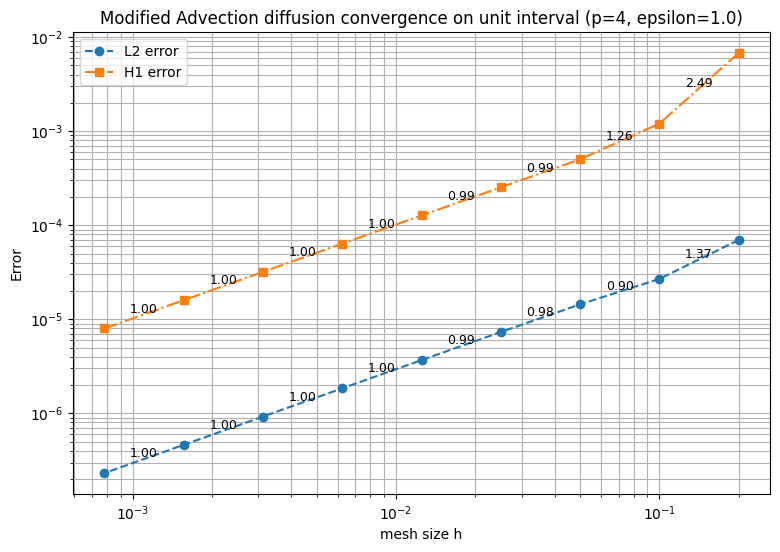

eps=0.1
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.13383e-03	        	1.19707e-01	        
1.00000e-01	2.17389e-03	   0.528	6.53924e-02	   0.872
5.00000e-02	1.32635e-03	   0.713	3.84123e-02	   0.768
2.50000e-02	7.42921e-04	   0.836	2.12104e-02	   0.857
1.25000e-02	3.95039e-04	   0.911	1.11893e-02	   0.923
6.25000e-03	2.03969e-04	   0.954	5.75270e-03	   0.960
3.12500e-03	1.03674e-04	   0.976	2.91750e-03	   0.980
1.56250e-03	5.22692e-05	   0.988	1.46925e-03	   0.990
7.81250e-04	2.62440e-05	   0.994	7.37279e-04	   0.995


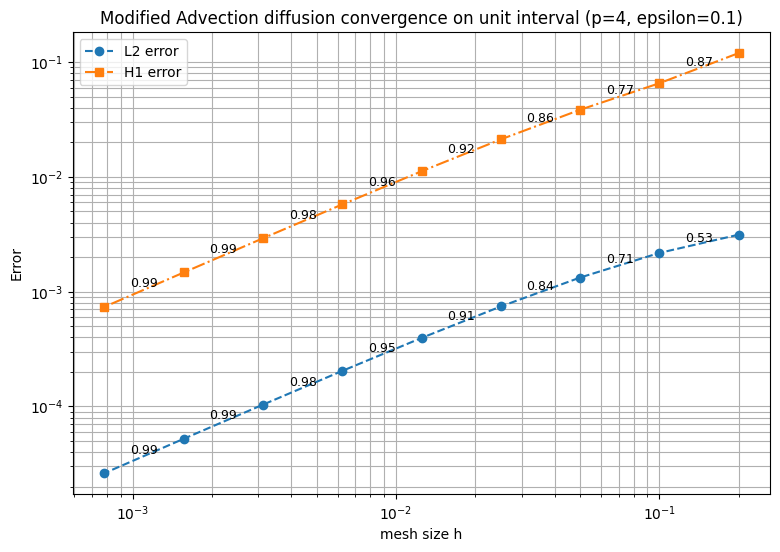

eps=0.01
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	2.93316e-02	        	5.90374e-01	        
1.00000e-01	2.48588e-02	   0.239	5.38089e-01	   0.134
5.00000e-02	1.75936e-02	   0.499	4.43113e-01	   0.280
2.50000e-02	1.02489e-02	   0.780	3.02956e-01	   0.549
1.25000e-02	5.35289e-03	   0.937	1.82947e-01	   0.728
6.25000e-03	2.69784e-03	   0.989	1.02565e-01	   0.835
3.12500e-03	1.34897e-03	   1.000	5.47980e-02	   0.904
1.56250e-03	6.73831e-04	   1.001	2.84130e-02	   0.948
7.81250e-04	3.36671e-04	   1.001	1.44808e-02	   0.972


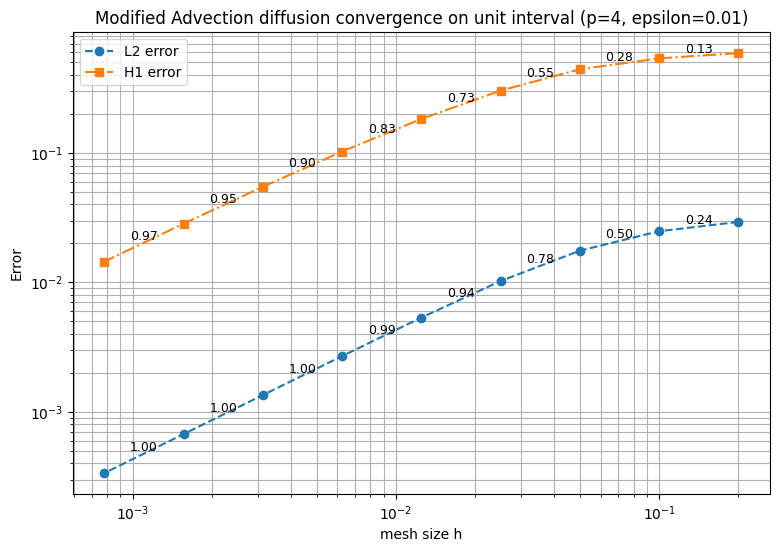

eps=0.001
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32151e-02	        	6.76984e-01	        
1.00000e-01	2.81087e-02	   0.241	6.14010e-01	   0.141
5.00000e-02	1.88283e-02	   0.578	5.06496e-01	   0.278
2.50000e-02	1.03329e-02	   0.866	4.40296e-01	   0.202
1.25000e-02	5.67970e-03	   0.863	4.98505e-01	  -0.179
6.25000e-03	3.43800e-03	   0.724	6.38475e-01	  -0.357
3.12500e-03	2.34704e-03	   0.551	8.06843e-01	  -0.338
1.56250e-03	1.81218e-03	   0.373	9.67766e-01	  -0.262
7.81250e-04	1.54956e-03	   0.226	1.09563e+00	  -0.179


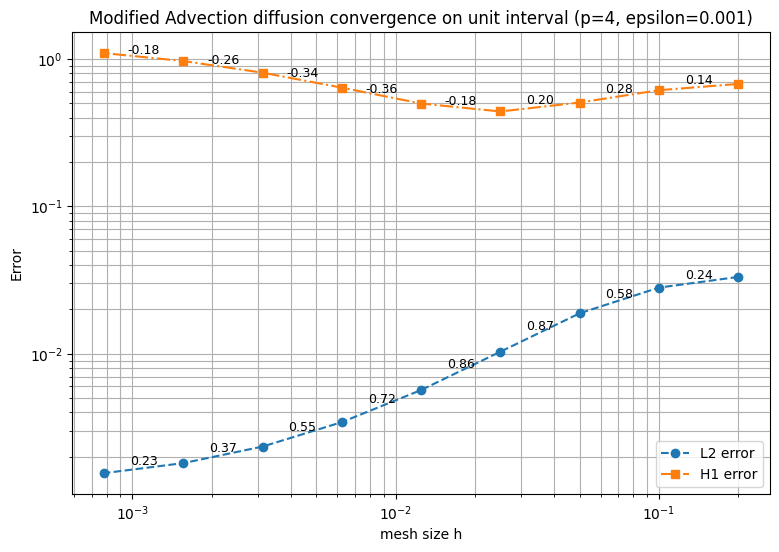

eps=0.0001
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32928e-02	        	6.81777e-01	        
1.00000e-01	2.80942e-02	   0.245	6.22931e-01	   0.130
5.00000e-02	1.86168e-02	   0.594	5.16955e-01	   0.269
2.50000e-02	1.00963e-02	   0.883	4.55683e-01	   0.182
1.25000e-02	5.48643e-03	   0.880	5.33835e-01	  -0.228
6.25000e-03	3.19711e-03	   0.779	7.24164e-01	  -0.440
3.12500e-03	1.99794e-03	   0.678	1.00405e+00	  -0.471
1.56250e-03	1.33361e-03	   0.583	1.37839e+00	  -0.457
7.81250e-04	9.47339e-04	   0.493	1.84736e+00	  -0.422


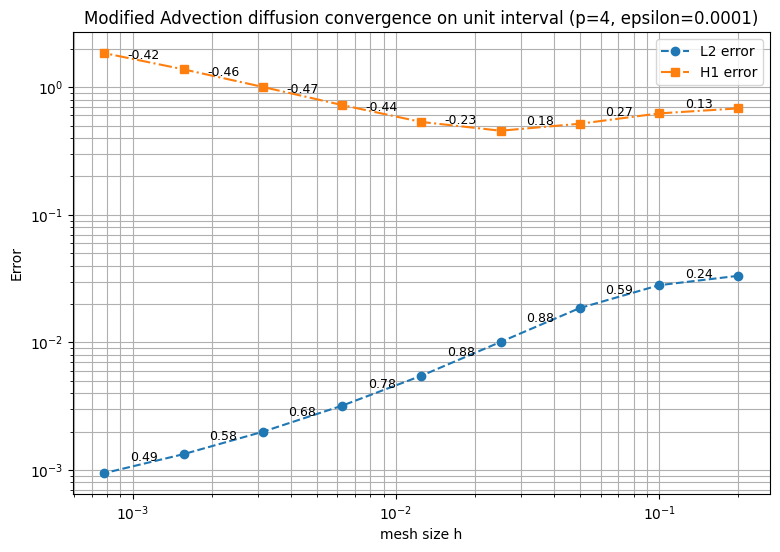

eps=1e-05
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32976e-02	        	6.82225e-01	        
1.00000e-01	2.80899e-02	   0.245	6.23802e-01	   0.129
5.00000e-02	1.85935e-02	   0.595	5.17991e-01	   0.268
2.50000e-02	1.00724e-02	   0.884	4.57266e-01	   0.180
1.25000e-02	5.46740e-03	   0.881	5.37719e-01	  -0.234
6.25000e-03	3.17234e-03	   0.785	7.34609e-01	  -0.450
3.12500e-03	1.95961e-03	   0.695	1.03247e+00	  -0.491
1.56250e-03	1.27569e-03	   0.619	1.45468e+00	  -0.495
7.81250e-04	8.63954e-04	   0.562	2.04423e+00	  -0.491


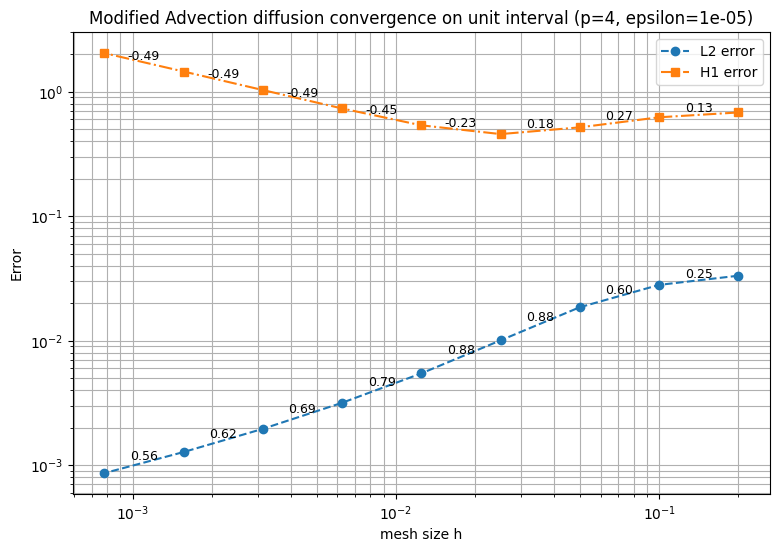

eps=1e-06
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82269e-01	        
1.00000e-01	2.80894e-02	   0.245	6.23889e-01	   0.129
5.00000e-02	1.85911e-02	   0.595	5.18095e-01	   0.268
2.50000e-02	1.00700e-02	   0.885	4.57425e-01	   0.180
1.25000e-02	5.46550e-03	   0.882	5.38112e-01	  -0.234
6.25000e-03	3.16986e-03	   0.786	7.35677e-01	  -0.451
3.12500e-03	1.95573e-03	   0.697	1.03545e+00	  -0.493
1.56250e-03	1.26974e-03	   0.623	1.46302e+00	  -0.499
7.81250e-04	8.55154e-04	   0.570	2.06755e+00	  -0.499


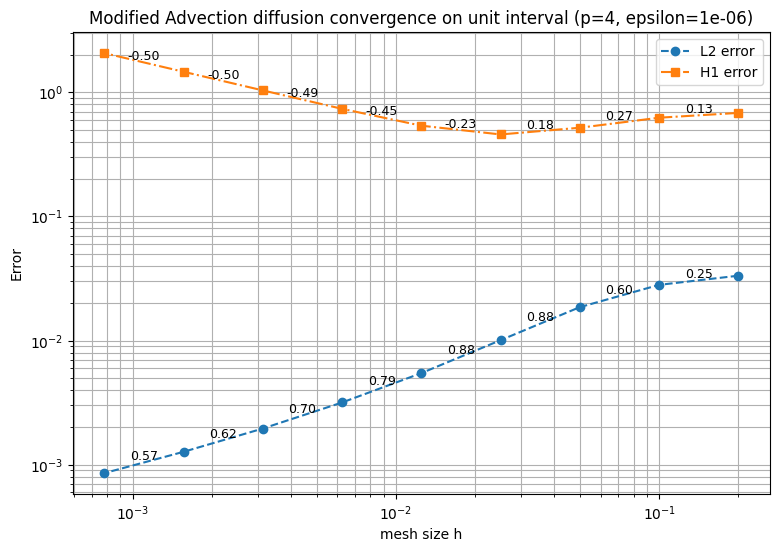

eps=1e-07
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82274e-01	        
1.00000e-01	2.80893e-02	   0.245	6.23898e-01	   0.129
5.00000e-02	1.85909e-02	   0.595	5.18105e-01	   0.268
2.50000e-02	1.00698e-02	   0.885	4.57441e-01	   0.180
1.25000e-02	5.46531e-03	   0.882	5.38151e-01	  -0.234
6.25000e-03	3.16961e-03	   0.786	7.35784e-01	  -0.451
3.12500e-03	1.95534e-03	   0.697	1.03575e+00	  -0.493
1.56250e-03	1.26915e-03	   0.624	1.46386e+00	  -0.499
7.81250e-04	8.54268e-04	   0.571	2.06992e+00	  -0.500


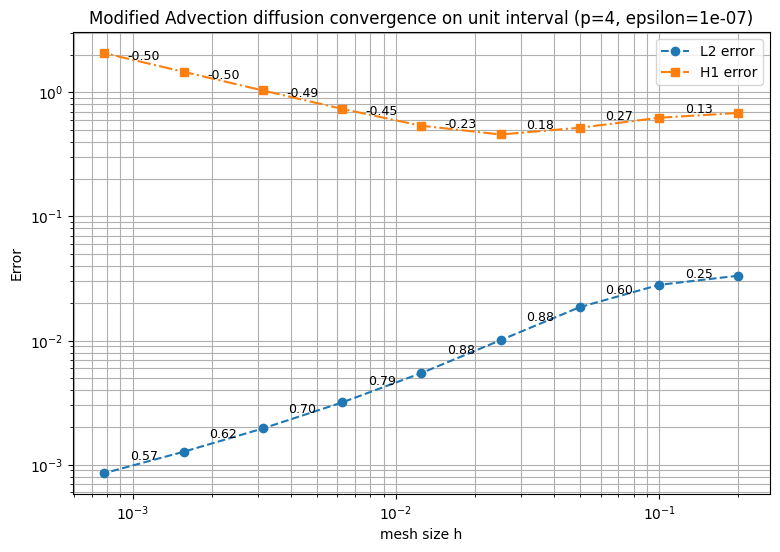

eps=1e-08
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82274e-01	        
1.00000e-01	2.80893e-02	   0.245	6.23899e-01	   0.129
5.00000e-02	1.85908e-02	   0.595	5.18106e-01	   0.268
2.50000e-02	1.00698e-02	   0.885	4.57442e-01	   0.180
1.25000e-02	5.46530e-03	   0.882	5.38155e-01	  -0.234
6.25000e-03	3.16958e-03	   0.786	7.35795e-01	  -0.451
3.12500e-03	1.95530e-03	   0.697	1.03578e+00	  -0.493
1.56250e-03	1.26909e-03	   0.624	1.46394e+00	  -0.499
7.81250e-04	8.54180e-04	   0.571	2.07016e+00	  -0.500


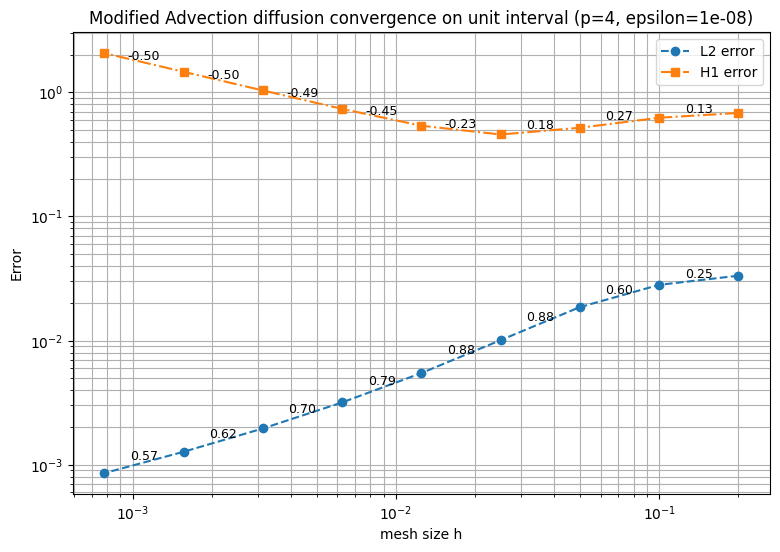

eps=1e-09
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82274e-01	        
1.00000e-01	2.80893e-02	   0.245	6.23899e-01	   0.129
5.00000e-02	1.85908e-02	   0.595	5.18106e-01	   0.268
2.50000e-02	1.00698e-02	   0.885	4.57443e-01	   0.180
1.25000e-02	5.46529e-03	   0.882	5.38155e-01	  -0.234
6.25000e-03	3.16958e-03	   0.786	7.35796e-01	  -0.451
3.12500e-03	1.95530e-03	   0.697	1.03578e+00	  -0.493
1.56250e-03	1.26908e-03	   0.624	1.46395e+00	  -0.499
7.81250e-04	8.54171e-04	   0.571	2.07018e+00	  -0.500


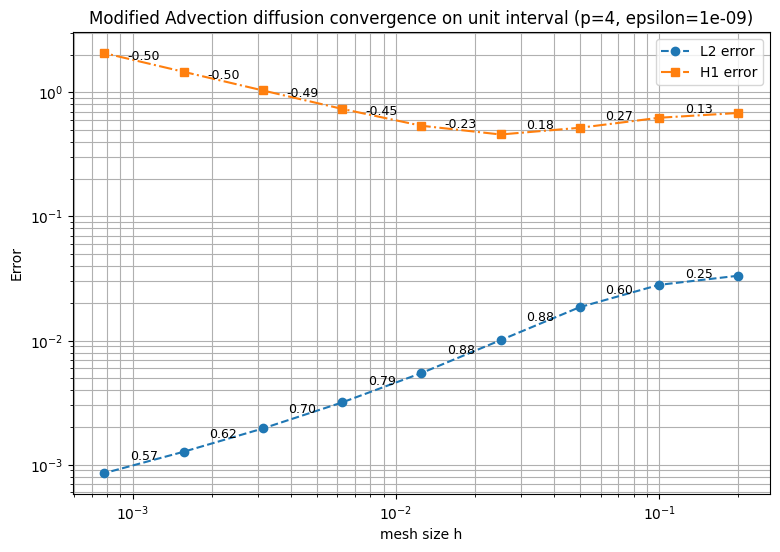

eps=1e-10
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82274e-01	        
1.00000e-01	2.80893e-02	   0.245	6.23899e-01	   0.129
5.00000e-02	1.85908e-02	   0.595	5.18106e-01	   0.268
2.50000e-02	1.00698e-02	   0.885	4.57443e-01	   0.180
1.25000e-02	5.46529e-03	   0.882	5.38155e-01	  -0.234
6.25000e-03	3.16958e-03	   0.786	7.35796e-01	  -0.451
3.12500e-03	1.95530e-03	   0.697	1.03578e+00	  -0.493
1.56250e-03	1.26908e-03	   0.624	1.46395e+00	  -0.499
7.81250e-04	8.54170e-04	   0.571	2.07019e+00	  -0.500


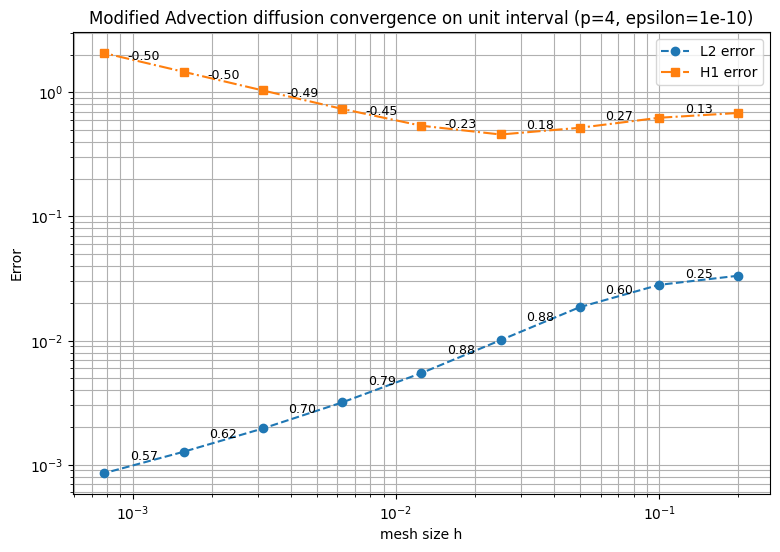

eps=1e-11
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82274e-01	        
1.00000e-01	2.80893e-02	   0.245	6.23899e-01	   0.129
5.00000e-02	1.85908e-02	   0.595	5.18106e-01	   0.268
2.50000e-02	1.00698e-02	   0.885	4.57443e-01	   0.180
1.25000e-02	5.46529e-03	   0.882	5.38155e-01	  -0.234
6.25000e-03	3.16958e-03	   0.786	7.35796e-01	  -0.451
3.12500e-03	1.95530e-03	   0.697	1.03578e+00	  -0.493
1.56250e-03	1.26908e-03	   0.624	1.46395e+00	  -0.499
7.81250e-04	8.54170e-04	   0.571	2.07019e+00	  -0.500


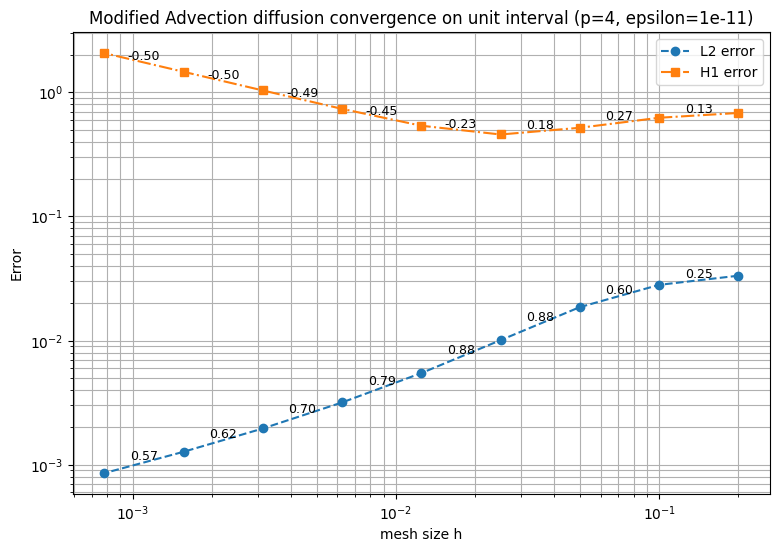

eps=1e-12
order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
2.00000e-01	3.32981e-02	        	6.82274e-01	        
1.00000e-01	2.80893e-02	   0.245	6.23899e-01	   0.129
5.00000e-02	1.85908e-02	   0.595	5.18106e-01	   0.268
2.50000e-02	1.00698e-02	   0.885	4.57443e-01	   0.180
1.25000e-02	5.46529e-03	   0.882	5.38155e-01	  -0.234
6.25000e-03	3.16958e-03	   0.786	7.35796e-01	  -0.451
3.12500e-03	1.95530e-03	   0.697	1.03578e+00	  -0.493
1.56250e-03	1.26908e-03	   0.624	1.46395e+00	  -0.499
7.81250e-04	8.54170e-04	   0.571	2.07019e+00	  -0.500


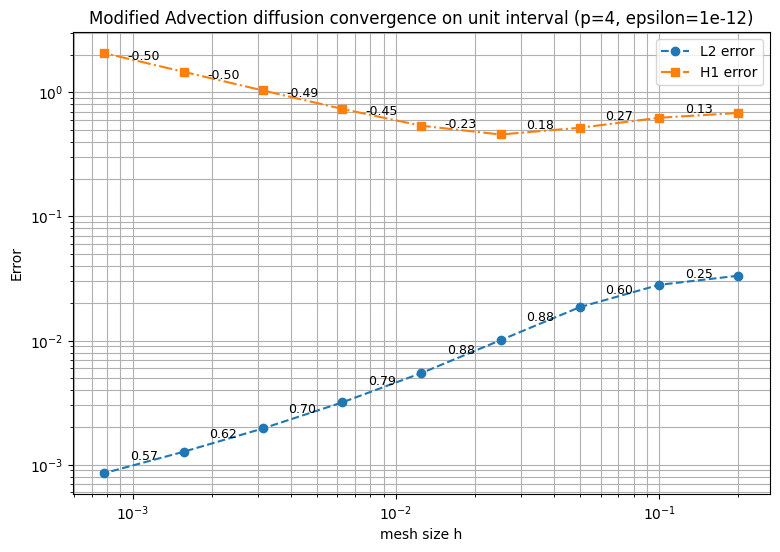

In [46]:
all_modified_studies = {}

for eps in eps_list:
    solver = get_modified_solver(eps, beta=1)
    study = run_study(
        solve_fn=solver,
        hs=hs,
        orders=order,
        params_list=[{}],
        err_L2_fn=err_L2_advecdiff,
        err_H1_fn=err_H1_advecdiff,
        store_solution=True,
    )
    grp = study.group(order=order, params={})

    print(f"{eps=}")
    print(grp.table())
    grp.plot(title=f"Modified Advection diffusion convergence on unit interval (p={order}, epsilon={eps})")
    all_modified_studies[eps] = study